In [1]:
import pickle
import datetime
from pathlib import Path

import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
#from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from libs_unet.models import peakyfinder_0002
from libs_unet.training.libs_train import train_loop, test_loop
import matplotlib.pyplot as plt

top_dir = Path.cwd()
datapath = top_dir / 'data'

In [2]:
#training data import
with open(datapath / 'training' / 'el80_pairs_lg.pickle', 'rb') as f:
    elem_symb = pickle.load(f)
    el_index = pickle.load(f)
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)

In [3]:
#Scale data to account for source
nist_mult = 1.17
x_data = nist_mult * x_data
y_data = nist_mult * y_data

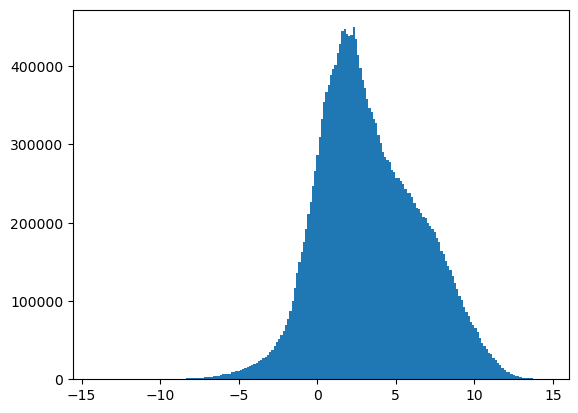

In [4]:
#Histogram of input data intensities to help define Hi/Low split point
n_bins = 200
plt.hist(np.log(x_data.reshape(-1)), bins = n_bins)
plt.show() # log(intens) < 2 seems a reasonable cutoff for the low intensity data

In [5]:
#split x_data into mutex low_int and log(hi_int) input channels
x_data = x_data[:,None,:]
x_shape = x_data.shape
new_inp = np.zeros((x_shape[0], 2, x_shape[2]))
log_cut = 2
new_inp[:,0,:] = np.where(np.log(x_data[:,0,:]) < log_cut, x_data[:,0,:], 0)
new_inp[:,1,:] = np.where(np.log(x_data[:,0,:]) >= log_cut, np.log(x_data[:,0,:]), 0)
x_data = new_inp.copy()
new_inp = None


In [6]:
#quick check for mutex on first sample only
both_pop = 0
for i in range(len(wave)):
    if x_data[0][0][i] > 0 and x_data[0][1][i] > 0:
        both_pop +=1
print(both_pop)

0


In [7]:
#create dataset
#input has two channels
#apply a scaling factor to standardize spectra across sources.
x_data = torch.tensor(x_data.astype('float32'))
y_data = torch.tensor(y_data.astype('float32'))
x_data[x_data < 0] = 0
y_data[y_data < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
#x_data = torch.log(x_data + 1)
y_data = torch.log(y_data + 1)

spec_ds = TensorDataset(x_data, y_data)
#batch sizes
train_bs = 50
test_bs = 100
#create random split for training and validation
train_len = int(0.8 * len(x_data))
test_len = len(x_data) - train_len
train_ds, test_ds = random_split(spec_ds,[train_len, test_len])
train_dl = DataLoader(train_ds, batch_size=train_bs, shuffle=True) #check if shuffle redundant
test_dl = DataLoader(test_ds, batch_size=test_bs)
#

In [8]:
#set parameters
max_z = len(elem_symb)
wl_points = len(wave) #number of wavelength point measurements in data
learning_rate = 1 #There is a schedule to reduce as loss plateaus
epochs = 1

#Initialize and run
model = peakyfinder_0002.LIBSUNet(max_z, wl_points)
loss_fn = nn.MSELoss(reduction='mean')
#loss_fn = Custom_Wgt_MSE(loss_wts)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = MultiStepLR(optimizer, [], 0.5)

now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') #  now 
writerpath = top_dir / 'runs' / now_time
writer = SummaryWriter(writerpath)

for t in range(epochs):
    print(f"Epoch {t+1}, learning rate {optimizer.param_groups[0]['lr']}\n-------------------------------")
    train_loop(train_dl, model, loss_fn, optimizer, writer, t+1, debug=True, bsize=train_bs)
    test_loss = test_loop(test_dl, model, loss_fn, writer, t+1)
    lr_scheduler.step()
print("Done!")

#cleanup
writer.flush()
writer.close()


Epoch 1, learning rate 1
-------------------------------


In [4]:
#Save model parameters for use in Model_Test notebook
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
param_path = top_dir / 'trained_models' / 'el80_pairs_lg_0001'
torch.save(model.state_dict(), param_path)

Use Model_Test.ipynb to load and review model prediction on sample / experimental data